In [93]:
from pymongo import MongoClient
import os
from pathlib import Path
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mauriciobarrosdejesus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
BASE_DIR = Path(os.path.abspath('')).resolve()

### Get Dataset


In [3]:
dfSentencas = pd.read_parquet(Path(os.path.join(BASE_DIR,'dataset', 'processed','legislacao_base_sentencas.parquet')), engine='fastparquet')
dfSentencas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7182 entries, 0 to 7181
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   path                 7182 non-null   object 
 1   id_doc_base          7182 non-null   object 
 2   name                 7182 non-null   object 
 3   esfera               7182 non-null   object 
 4   cat                  7182 non-null   object 
 5   ementa               7182 non-null   object 
 6   id_sentenca          7181 non-null   object 
 7   ordem                7181 non-null   float64
 8   tokens_total         7181 non-null   float64
 9   tokens_no_stopwords  7181 non-null   float64
 10  cat_sentenca         7181 non-null   object 
 11  text_sentenca        7181 non-null   object 
dtypes: float64(3), object(9)
memory usage: 729.4+ KB


In [4]:
dfTS = dfSentencas[dfSentencas['cat']=='terceiro_setor']
dfTS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1084
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   path                 1085 non-null   object 
 1   id_doc_base          1085 non-null   object 
 2   name                 1085 non-null   object 
 3   esfera               1085 non-null   object 
 4   cat                  1085 non-null   object 
 5   ementa               1085 non-null   object 
 6   id_sentenca          1084 non-null   object 
 7   ordem                1084 non-null   float64
 8   tokens_total         1084 non-null   float64
 9   tokens_no_stopwords  1084 non-null   float64
 10  cat_sentenca         1084 non-null   object 
 11  text_sentenca        1084 non-null   object 
dtypes: float64(3), object(9)
memory usage: 110.2+ KB


In [95]:
txtListTercSetor = dfSentencas["text_sentenca"].to_list()
##Drop None
txtListTercSetor = [x for x in txtListTercSetor if x is not None]
all_summary = " ".join(str(s).lower() for s in txtListTercSetor)

In [107]:
stopwords.update(["art", "deste", "outro", "ii", "iii", "art", "artigo","iv","n","nr","desta","deste","ainda","caso"])

text_tokens = word_tokenize(all_summary)
tokens_without_sw = [word for word in text_tokens if not word in stopwords]
all_summary = " ".join(s for s in tokens_without_sw)

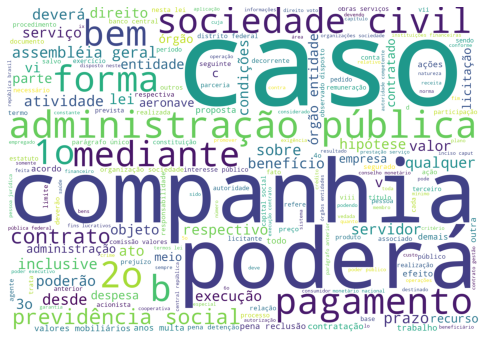

In [108]:
# gerar uma wordcloud
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=2600, height=1800).generate(all_summary)
# mostrar a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)
wordcloud.to_file("terc_setor_wordcloud.png")

In [5]:
listaDfDocs = []
nrDocs = 2500

##Gerar docs
for i in range(0,nrDocs):
    
    maxIteration = 10
    totalToken = 0
    nrIteration = 0
    dfText = pd.DataFrame()
    
    while totalToken < 512:
        
        dfSample = dfTS.sample(replace=False)
        dfSample_tokens_total = dfSample["tokens_no_stopwords"].iloc[0]
        dfText = pd.concat([dfText,dfSample])
        
        totalToken = totalToken + dfSample_tokens_total

        if(nrIteration > maxIteration):
            break
        
        nrIteration = nrIteration + 1

    listaDfDocs.append(dfText)


In [6]:
listaIdDocBase = []
listaIdSentenca = []
for dfTextProc in listaDfDocs:
    for index,row in dfTextProc.iterrows():
        listaIdDocBase.append(row["id_doc_base"])
        listaIdSentenca.append(row["id_sentenca"])
        

In [7]:
countDocBase = [[x,listaIdDocBase.count(x)] for x in set(listaIdDocBase)]
countSentenca = [[x,listaIdSentenca.count(x)] for x in set(listaIdSentenca)]

<AxesSubplot:ylabel='Count'>

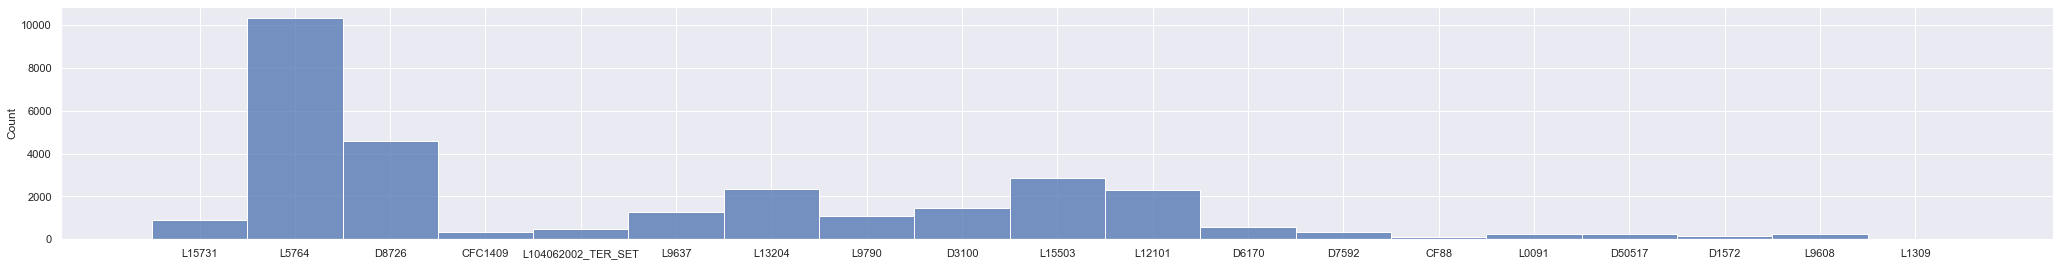

In [17]:
sns.set(rc={'figure.figsize':(35.7,4.27)})
sns.histplot(data=listaIdDocBase, discrete=True)

<AxesSubplot:ylabel='Count'>

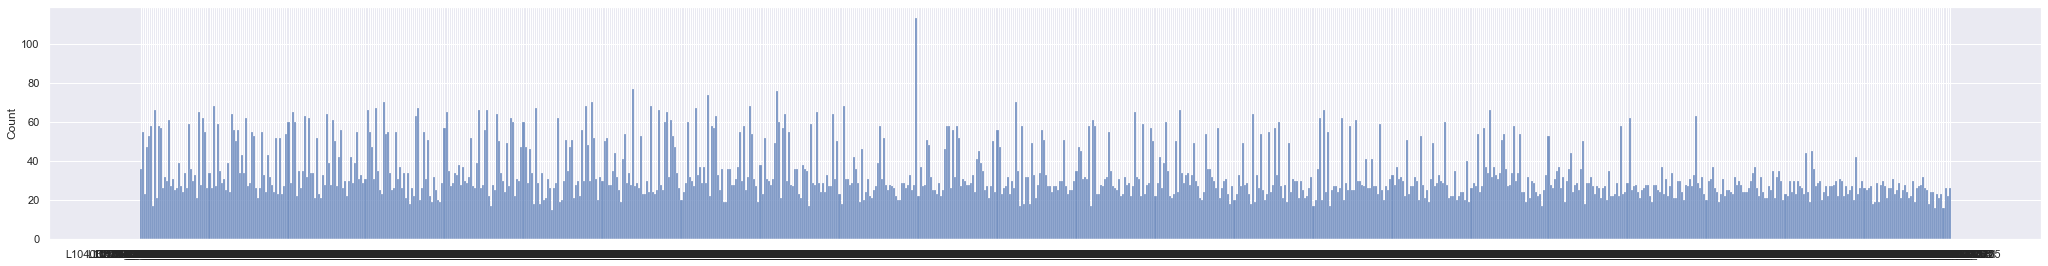

In [18]:
sns.set(rc={'figure.figsize':(35.7,4.27)})
sns.histplot(data=listaIdSentenca, discrete=True)

In [58]:
dfTreino = pd.DataFrame()

for dfTextProc in listaDfDocs:
    txtList = dfTextProc["text_sentenca"].to_list()

    ##Drop None
    txtList = [x for x in txtList if x is not None]
    
    try:
        txt = ' '.join(txtList)
    except Exception as e:
        print(e, txtList)

    reg = {  "cat":"terceiro_setor"
            ,"text":txt
        }
        
    dfTreino = pd.concat([dfTreino,pd.DataFrame([reg])])
    
  

In [59]:
dfTreino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     2500 non-null   object
 1   text    2500 non-null   object
dtypes: object(2)
memory usage: 58.6+ KB


In [61]:
dfTreino.head(2)

,cat,text
0,terceiro_setor,"Para os efeitos desta Lei, considera-se sem fi..."
0,terceiro_setor,III C) A ENTIDADE BENEFICIÁRIA DEVERÁ SER ORGA...


### Gerar Outras Categorias

In [62]:
dfOutros = dfSentencas[dfSentencas['cat']!='terceiro_setor']
dfOutros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6097 entries, 1085 to 7181
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   path                 6097 non-null   object 
 1   id_doc_base          6097 non-null   object 
 2   name                 6097 non-null   object 
 3   esfera               6097 non-null   object 
 4   cat                  6097 non-null   object 
 5   ementa               6097 non-null   object 
 6   id_sentenca          6097 non-null   object 
 7   ordem                6097 non-null   float64
 8   tokens_total         6097 non-null   float64
 9   tokens_no_stopwords  6097 non-null   float64
 10  cat_sentenca         6097 non-null   object 
 11  text_sentenca        6097 non-null   object 
dtypes: float64(3), object(9)
memory usage: 619.2+ KB


In [63]:
listaDfDocs = []
nrDocs = 2500
##Gerar docs
for i in range(0,nrDocs):
    
    maxIteration = 10
    totalToken = 0
    nrIteration = 0
    dfText = pd.DataFrame()
    
    while totalToken < 512:
        
        dfSample = dfOutros.sample(replace=False)
        dfSample_tokens_total = dfSample["tokens_no_stopwords"].iloc[0]
        dfText = pd.concat([dfText,dfSample])
        
        totalToken = totalToken + dfSample_tokens_total

        if(nrIteration > maxIteration):
            break
        
        nrIteration = nrIteration + 1

    listaDfDocs.append(dfText)


In [65]:
listaIdDocBase = []
listaIdSentenca = []
for dfTextProc in listaDfDocs:
    for index,row in dfTextProc.iterrows():
        listaIdDocBase.append(row["id_doc_base"])
        listaIdSentenca.append(row["id_sentenca"])
        

In [66]:
countDocBase = [[x,listaIdDocBase.count(x)] for x in set(listaIdDocBase)]
countSentenca = [[x,listaIdSentenca.count(x)] for x in set(listaIdSentenca)]

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

<AxesSubplot:ylabel='Count'>

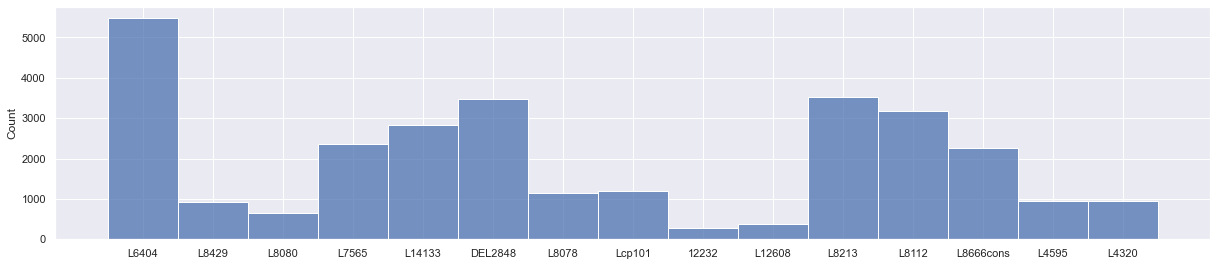

In [72]:
sns.set(rc={'figure.figsize':(20.7,4.27)})
sns.histplot(data=listaIdDocBase, discrete=True)

In [75]:
for dfTextProc in listaDfDocs:
    txtList = dfTextProc["text_sentenca"].to_list()
    txt = ' '.join(txtList)
    
    ##Drop None
    txtList = [x for x in txtList if x is not None]

    reg = {  "cat":"outros"
             ,"text":txt
          }
        
    dfTreino = pd.concat([dfTreino,pd.DataFrame([reg])])
  

In [76]:
dfTreino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     5000 non-null   object
 1   text    5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [77]:

## Saving dataset
dfTreino.to_parquet(Path(os.path.join(BASE_DIR,'dataset', 'processed','dataset_treino.parquet')), engine='fastparquet')